In [1]:
% matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets, models, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
import os

гиперпараметры: 

In [11]:
batch_size = 16
G_lr = D_lr = 1e-3
global_step = 0
print_every = 1000 
total_steps = 5000 # mb v paru raz umen'shit'
cost_func = nn.BCELoss()

D_ent = 100
D_side = 28
D_img = D_side**2
D_hidden = 128

лоадеры

In [12]:
modes = ['train', 'val']
trans = transforms.Compose([transforms.ToTensor(),]) 
dsets = {k: datasets.MNIST('./data', train=k=='train', download=True, transform=trans) for k in modes}
loaders = {k: torch.utils.data.DataLoader(dsets[k], batch_size=batch_size, shuffle=True) for k in modes}

def entropy():
    return Variable(torch.randn(batch_size, D_ent))

def mnist():
    data = next(iter(loaders['train']))[0]
    return Variable(data).resize(batch_size, D_img)

рисуем:

C:\Users\User3\Anaconda3\lib\site-packages\torch\tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


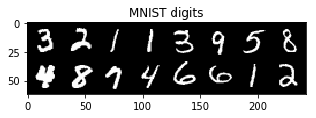

In [13]:
def imshow(inp, c, save=False, title=None):
    
    fig = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    
    plt.title(title) if title is not None else plt.title(str(c).zfill(3))
    if save:
        if not os.path.exists('vanilla-out/'):
            os.makedirs('vanilla-out/')
        plt.savefig('vanilla-out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        plt.close(fig)

inputs = mnist().data.resize_(batch_size,1,D_side,D_side)
out = utils.make_grid(inputs)
imshow(out, c=0, save=False, title="MNIST digits")

дискриминатор + генератор: 

In [14]:
class SimpleNN(torch.nn.Module):
    def __init__(self, batch_size, input_dim, h_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.W1 = nn.Parameter(torch.randn(input_dim, h_dim)*0.075)
        self.b1 = nn.Parameter(torch.randn(h_dim)*0.075)
        self.W2 = nn.Parameter(torch.randn(h_dim, output_dim)*0.075)
        self.b2 = nn.Parameter(torch.randn(output_dim)*0.075)

    def forward(self, X):
        h = F.relu(X.mm(self.W1) + self.b1.repeat(X.size(0), 1))
        return F.sigmoid(h.mm(self.W2) + self.b2.repeat(X.size(0), 1))
    
class SimpleNN_G(torch.nn.Module):
    def __init__(self, batch_size, input_dim, h_dim, output_dim):
        super(SimpleNN_G, self).__init__()
        self.W1 = nn.Parameter(torch.randn(input_dim, h_dim)*0.075)
        self.b1 = nn.Parameter(torch.randn(h_dim)*0.075)
        self.W2 = nn.Parameter(torch.randn(input_dim, h_dim)*0.075)
        self.b2 = nn.Parameter(torch.randn(h_dim)*0.075)
        self.W3 = nn.Parameter(torch.randn(h_dim, output_dim)*0.075)
        self.b3 = nn.Parameter(torch.randn(output_dim)*0.075)

    def forward(self, X):
        h = F.relu(X.mm(self.W1) + self.b1.repeat(X.size(0), 1))
        h = F.relu(X.mm(self.W2) + self.b2.repeat(X.size(0), 1))
        return F.sigmoid(h.mm(self.W3) + self.b3.repeat(X.size(0), 1))
    
    
D = SimpleNN(batch_size, D_img, D_hidden, 1)
G = SimpleNN_G(batch_size, D_ent, D_hidden, D_img)

тренируем: 

In [15]:
optimizers = {'D': torch.optim.Adam(D.parameters(), lr=D_lr),
              'G': torch.optim.Adam(G.parameters(), lr=G_lr)}
ones_label = Variable(torch.ones(batch_size))
zeros_label = Variable(torch.zeros(batch_size))


for global_step in range(global_step, total_steps+global_step+1):
    
    # дискриминатор:
    # forward
    z = entropy() ; X = mnist()
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    # backward
    D_loss_real = cost_func(D_real, ones_label)
    D_loss_fake = cost_func(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    optimizers['D'].step()
    [o.zero_grad() for o in optimizers.values()]
    
    # генератор: 
    # forward
    z = entropy()
    G_sample = G(z)
    D_fake = D(G_sample)
    
    # backward
    G_loss = cost_func(D_fake, ones_label)
    G_loss.backward()
    optimizers['G'].step()
    [o.zero_grad() for o in optimizers.values()]

    # принтим лосс каждые принт_эври шагов
    if global_step % print_every == 0:
        
        #print(D_loss.data.numpy())
        
        print('step {}: D loss: {}; G loss: {}'
              .format(global_step, D_loss.data.numpy(), G_loss.data.numpy()))
        
        samples = G(entropy()).data.resize_(batch_size,1,D_side,D_side)
        samples = utils.make_grid(samples)
        imshow(samples, c = global_step // print_every, save=True)

C:\Users\User3\Anaconda3\lib\site-packages\torch\tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
C:\Users\User3\Anaconda3\lib\site-packages\torch\nn\functional.py:1474: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


step 0: D loss: 1.5512340068817139; G loss: 1.2204540967941284
step 1000: D loss: 0.002291296375915408; G loss: 10.645528793334961
step 2000: D loss: 0.0041553061455488205; G loss: 7.68247127532959
step 3000: D loss: 0.10422545671463013; G loss: 4.950864791870117
step 4000: D loss: 0.1399933397769928; G loss: 4.457048416137695
step 5000: D loss: 0.3690626323223114; G loss: 3.982546329498291


посмотрим че получилось:

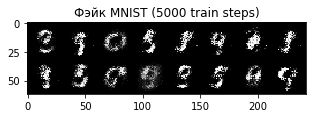

In [17]:
samples = G(entropy()).data.resize_(batch_size,1,D_side,D_side)
samples = utils.make_grid(samples)
imshow(samples, c = global_step // print_every, save=False,
       title="Фэйк MNIST ({} train steps)".format(global_step))

Пойдет (вроде)